### 🎯 Modelo base ResNet18
Entrenamos un modelo ResNet18 con CIFAR-10. Vamos a _olvidar_ una serie de datos entrenando el modelo de cero con nuevos datos, y evaluar ambos modelos con un simple MIA.

In [12]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection
import pickle

# Suppress warnings and TensorFlow logs
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

In [2]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld:
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [3]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 4254072832
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.15.1')

___
Descargamos y preparamos los datos de CIFAR-10.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = keras.utils.split_dataset(held_out, left_size=0.2, seed=0)

In [5]:
def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465],
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)],
        invert=denorm,
        axis=-1,
    )

    if not denorm:
        image = rescale(image)
    return norms(image), label

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

(128, 32, 32, 3) (128, 1)


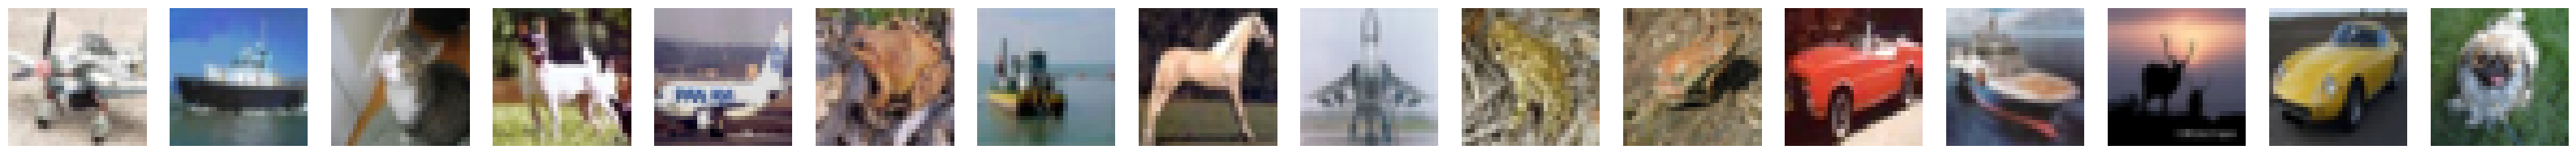

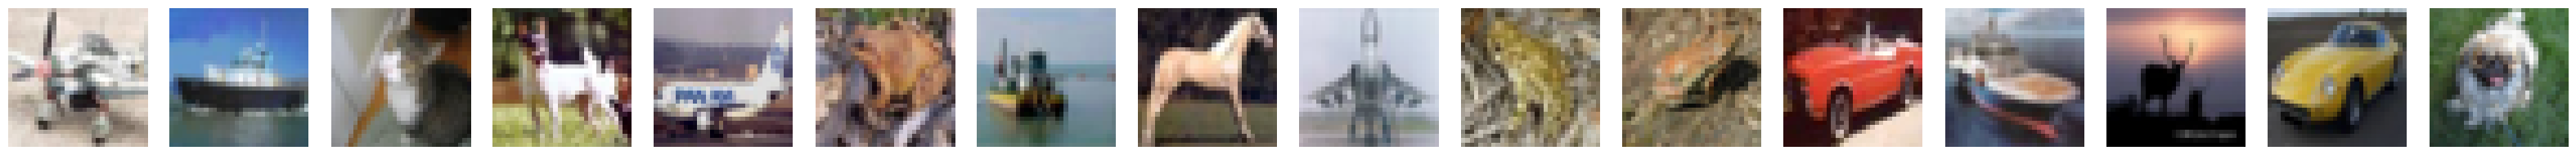

In [7]:
# Mostramos algunas de las imágenes de CIFAR-10

temp_ds = train_ds.map(lambda x,y:normalize(x,y, denorm=True))
images, labels = next(iter(temp_ds))
print(images.shape, labels.shape)

visualization.plot_image_gallery(
    images, value_range=(0,1), rows=1, cols=16
)

___
Preparamos y entrenamos el modelo ResNet18.

In [8]:
def get_model(model_name):
    with strategy.scope():
        model = keras.Sequential(
            [
                ResNet18Backbone(include_rescaling=False, input_shape=(32, 32, 3)),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model._name=model_name
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

    return model

def change_model_names(model, name, suffix):
    model._name=name
    """
    Change all layer names in the model by adding the given suffix.
    
    Parameters:
        model (tf.keras.Model): The Keras model.
        suffix (str): The string to add to the layer names.
    """
    # Iterate through the layers of the model
    for layer in model.layers:
        # Change the layer name by adding the suffix
        layer._name += suffix
        # If the layer is a backbone, recursively change the sublayers' names
        if hasattr(layer, 'layers'):
            change_model_names(layer, layer._name, suffix)

In [9]:
model = get_model('full_model')
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

change_model_names(model, 'full_model', '_full')

model.save("resnet18_cifar10.keras", save_format="keras_v3")

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

I0000 00:00:1716996203.163783   18423 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  7/391 [..............................] - ETA: 8s - loss: 3.1495 - accuracy: 0.1674   

W0000 00:00:1716996203.520695   18976 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 [==============================] - ETA: 0s - loss: 1.4292 - accuracy: 0.4944INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
391/391 [==============================] - 72s 102ms/step - loss: 1.4292 - accuracy: 0.4944 - val_loss: 1.3485 - val_accuracy: 0.5276
Epoch 2/20
391/391 [==============================] - 8s 21ms/step - loss: 1.0078 - accuracy: 0.6415 - val_loss: 1.3349 - val_accuracy: 0.5725

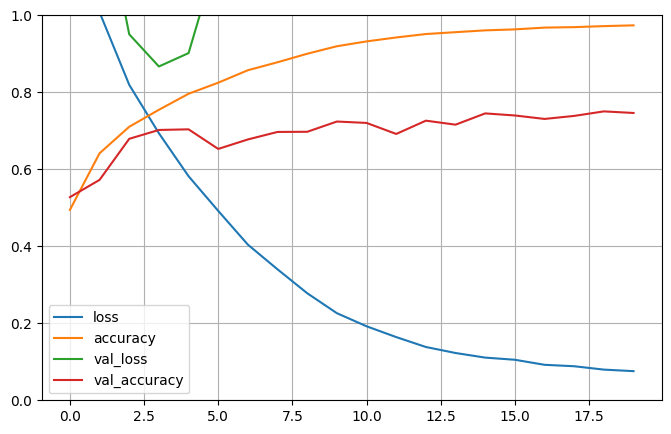

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_backbone_full (Res  (None, 1, 1, 512)         11186112  
 NetBackbone)                                                    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1_full (InputLayer)  [(None, 32, 32, 3)]       0        |
|                                                               |
| conv1_conv_full (Conv2D)   (None, 16, 16, 64)        9408     |
|                                                               |
| conv1_bn_full (BatchNorma  (None, 16, 16, 64)        256      |
| lization)                                                     |
|                                                               |
| conv1_relu_full (Activati  (None, 16, 16, 64)        0        |
| on)                                                           |
|                                                       

In [11]:
# Análisis del entrenamiento y el modelo

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

print(model.summary(expand_nested=True))

In [14]:
# Análisis de la exactitud en el conjunto de datos de entrenamiento

print(f"Train set accuracy: {100.0 * model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 10s 22ms/step - loss: 0.0923 - accuracy: 0.9690
Train set accuracy: 96.9%%
16/16 [==============================] - 0s 12ms/step - loss: 1.3440 - accuracy: 0.7450
Test set accuracy: 74.5%%


___
Entrenamos un modelo sin los datos a _olvidar_.

In [15]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
print('A olvidar:', int(forget_set.cardinality()),', a retener:', int(retain_set.cardinality()))

A olvidar: 5000 , a retener: 45000


In [17]:
retain_model = get_model('retain_model')
retain_history = retain_model.fit(retain_ds, validation_data=val_ds, epochs=20)

change_model_names(retain_model, 'retain_model', '_retain')

retain_model.save("resnet18_cifar10_retain.keras", save_format="keras_v3")

Epoch 1/20
INFO:tensorflow:Collective all_reduce tensors: 62 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 62 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective 

W0000 00:00:1716999371.284317   18976 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


352/352 [==============================] - ETA: 0s - loss: 1.4740 - accuracy: 0.4818INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
352/352 [==============================] - 57s 110ms/step - loss: 1.4740 - accuracy: 0.4818 - val_loss: 1.4037 - val_accuracy: 0.5255
Epoch 2/20
352/352 [==============================] - 12s 33ms/step - loss: 1.0350 - accuracy: 0.6336 - val_loss: 1.0726 - val_accuracy: 0.620

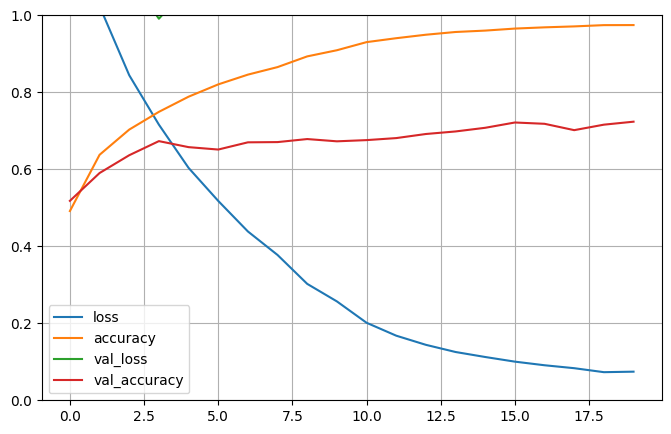

Model: "retain_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_backbone_retain (R  (None, 1, 1, 512)         11186112  
 esNetBackbone)                                                  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_2_retain (InputLaye  [(None, 32, 32, 3)]       0        |
| r)                                                            |
|                                                               |
| conv1_conv_retain (Conv2D  (None, 16, 16, 64)        9408     |
| )                                                             |
|                                                               |
| conv1_bn_retain (BatchNor  (None, 16, 16, 64)        256      |
| malization)                                                   |
|                                                               |
| conv1_relu_retain (Activa  (None, 16, 16, 64)       

In [14]:
# Análisis del entrenamiento y el modelo

pd.DataFrame(retain_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

print(retain_model.summary(expand_nested=True))

In [15]:
# Análisis de la exactitud en el conjunto de datos de entrenamiento

print(f"Train set accuracy: {100.0 * retain_model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * retain_model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 6s 15ms/step - loss: 0.2757 - accuracy: 0.9312
Train set accuracy: 93.1%%
16/16 [==============================] - 0s 13ms/step - loss: 1.4535 - accuracy: 0.7390
Test set accuracy: 73.9%%


___
Cuantificamos la calidad del algoritmo de desaprendizaje a través de un _membership inference attack_ simple (MIA).

Este MIA consiste en un modelo de regresión logística que predice si el modelo fue entrenado en una muestra particular a partir del _loss_ de esa muestra. Para tener una idea de la dificultad de este problema, primero graficamos a continuación un histograma de los _loss_-es del modelo preentrenado en el conjunto de entrenamiento y prueba.

In [18]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        reduction="none"
    )
    all_losses = []

    for inputs, targets in tqdm(loader):
        logits = net(inputs, training=False)
        losses = loss_fn(targets, logits).numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [19]:
train_losses = compute_losses(model, train_ds)
test_losses = compute_losses(model, test_ds)

100%|██████████| 16/16 [00:02<00:00,  6.57it/s]


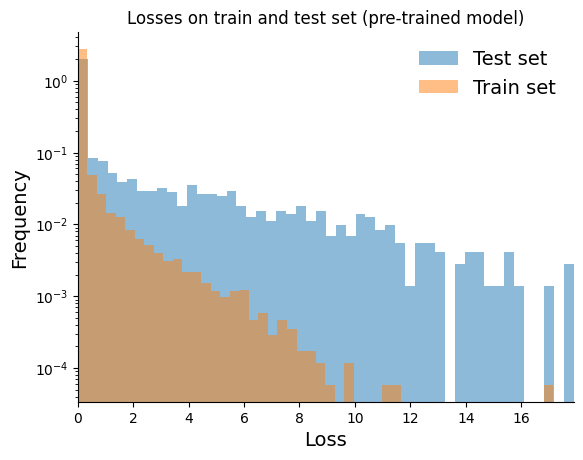

In [20]:
# Representar 'loss'-es en el conjunto de entrenamiento y prueba

plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

Según el gráfico anterior, las distribuciones de pérdidas son bastante diferentes entre los conjuntos de entrenamiento y prueba, como era de esperar. En lo que sigue, definiremos un MIA que aprovecha el hecho de que los ejemplos en los que se entrenó tienen pérdidas más pequeñas en comparación con los ejemplos que no lo fueron. Utilizando este hecho, el simple MIA definido a continuación intentará inferir si el conjunto de olvido fue de hecho parte del conjunto de entrenamiento.

Este MIA se define a continuación. Toma como entrada las pérdidas por muestra del modelo no aprendido en ejemplos de olvido y prueba, y una etiqueta de membresía (0 o 1) que indica de qué grupo proviene cada muestra. Luego devuelve la precisión de la validación cruzada de un modelo lineal entrenado para distinguir entre las dos clases.

De manera intuitiva, un algoritmo de desaprendizaje es exitoso con respecto a esta métrica simple si el atacante no puede distinguir el conjunto de olvido del conjunto de prueba (asociado con una precisión del atacante al azar).

In [23]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [62]:
# Recordamos los tamaños de los conjuntos
print(int(forget_set.cardinality()), int(test_set.cardinality()), int(val_set.cardinality()))

# forget_set   test_set   val_set

5000 2000 8000


In [31]:
forget_losses = compute_losses(model, forget_ds)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[:len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA attack has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

100%|██████████| 40/40 [00:04<00:00,  8.18it/s]

The MIA attack has an accuracy of 0.620 on forgotten vs unseen images


In [39]:
rt_test_losses = compute_losses(retain_model, test_ds)
rt_forget_losses = compute_losses(retain_model, forget_ds)

100%|██████████| 40/40 [00:05<00:00,  7.36it/s]


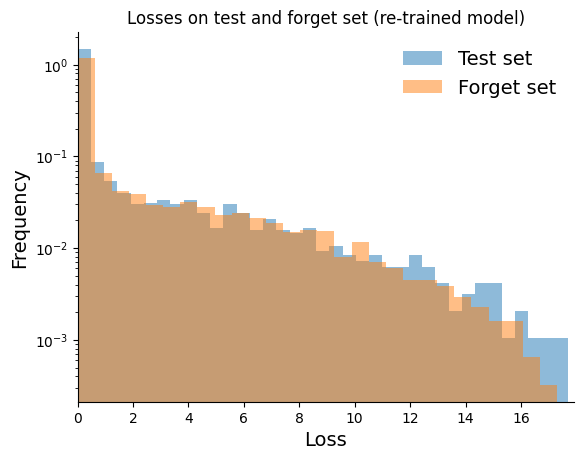

In [26]:
# Representar 'loss'-es en el conjunto de entrenamiento y prueba

plt.title("Losses on test and forget set (re-trained model)")
plt.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

In [43]:
# rt_forget_losses = compute_losses(retain_model, forget_ds)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(rt_forget_losses)
rt_forget_losses = rt_forget_losses[:len(rt_test_losses)]

samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

rt_mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA attack has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA attack has an accuracy of 0.490 on forgotten vs unseen images


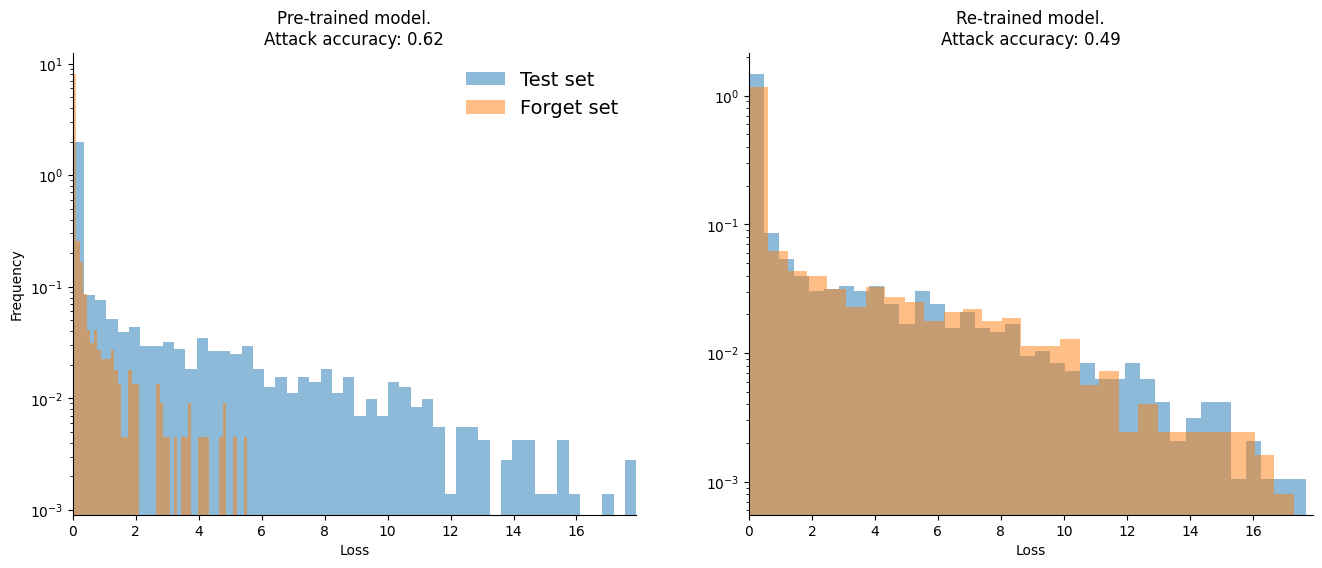

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

___
PICKLE

In [45]:
# Saving the objects:
with open('base.pkl', 'wb') as f:
    pickle.dump([history, test_losses, train_losses, forget_losses, rt_test_losses, rt_forget_losses, mia_scores, rt_mia_scores], f)

""" # Getting back the objects:
with open('objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    [] = pickle.load(f) """

" # Getting back the objects:\nwith open('objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')\n    [] = pickle.load(f) "